## Overview of all the BERT models vs the Assignment 2 models

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now we can take a look at how all of these models line up side by side in terms of average accuracy

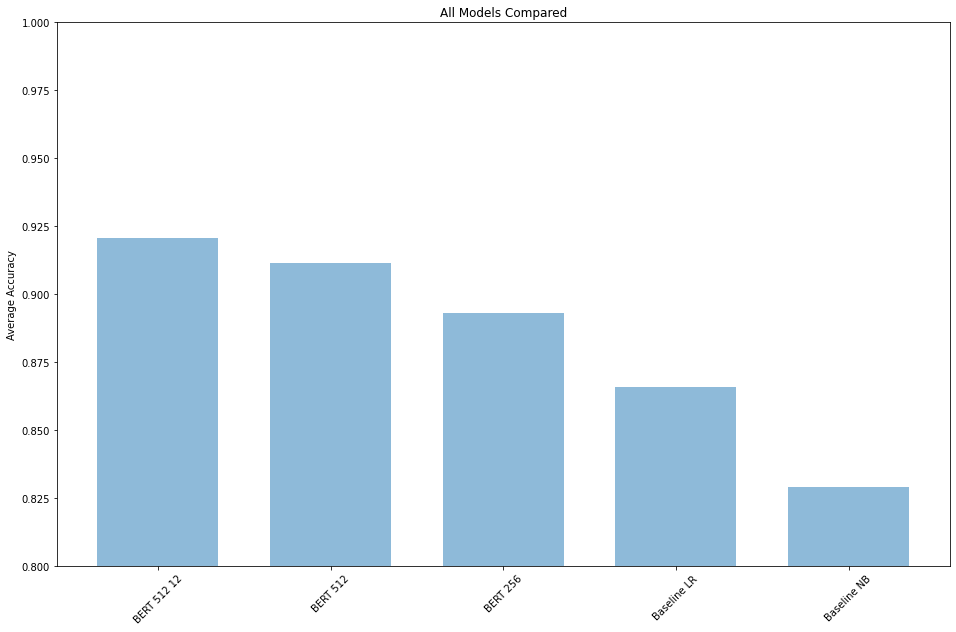

In [6]:
objects = ['Baseline NB', 'Baseline LR', 'BERT 256', 'BERT 512', 'BERT 512 12']
y_pos = np.arange(len(objects))
performance = [0.829,0.866,0.89306,0.9115,0.9205]
objects = [x for _,x in sorted(zip(performance,objects),reverse=True)]
performance = [x for x,_ in sorted(zip(performance,objects),reverse=True)]
plt.figure(figsize=(16, 10))
plt.bar(y_pos, performance, align='center', alpha=0.5, width=0.7)
plt.xticks(y_pos, objects)
plt.ylabel('Average Accuracy')
plt.title('All Models Compared')
plt.ylim([0.8, 1])
plt.xticks(rotation=45)
plt.show()

It's clear to see now that the BERT model that utilizes a max sequence length of 512 and runs for 12 Epochs is the best model across both assignments as we might have expected. It takes significantly longer than the other configurations of BERT for a somewhat magrinal improvement so it would be useful to weigh up the time you have vs. the quality you ultimately want before making a decision on which to implement.

The next step is to take a look at which reviews fool all of the models and then see what BERT can do better than the 2 more primitive models and vice versa

## What do all three models struggle with?

This first cell can largely be ignored as it is simply using code from the previous notebooks to build our list of errors that BERT has in the first CV fold

In [7]:
bert_512_12_files = []
    
for i in range(1,11):
    bert_512_12_files.append(f'512_12_BERT/{i}_pred_512_12.txt')
    
c_names = ['gold','pred','correct','text']

df1_512_12 = pd.DataFrame(columns=c_names)
df2_512_12 = pd.DataFrame(columns=c_names)
df3_512_12 = pd.DataFrame(columns=c_names)
df4_512_12 = pd.DataFrame(columns=c_names)
df5_512_12 = pd.DataFrame(columns=c_names)
df6_512_12 = pd.DataFrame(columns=c_names)
df7_512_12 = pd.DataFrame(columns=c_names)
df8_512_12 = pd.DataFrame(columns=c_names)
df9_512_12 = pd.DataFrame(columns=c_names)
df10_512_12 = pd.DataFrame(columns=c_names)

dataframes_512_12 = [df1_512_12,df2_512_12,df3_512_12,df4_512_12,df5_512_12,df6_512_12,df7_512_12,df8_512_12,df9_512_12,df10_512_12]

def create_dfs(files, df_list):
    j = 0
    for dataframe in df_list:

        #dataframe = pd.DataFrame(columns=['index','gold','pred','correct','text'])
        processed_lines = []

        with open(files[j], 'r') as f:
            lines = f.readlines()

            count = 0
            for line in lines[1:]:
                tokens = line.split()
                line_length = len(tokens)
                temp_line = ''

                for i in range(4, (line_length)):
                    temp_line = temp_line + tokens[i] + ' '

                processed_line = [tokens[1],tokens[2],tokens[3], temp_line]
                processed_lines.append(processed_line)
                dataframe.loc[count] = processed_line
                count+=1
        j+=1
    return(df_list)

dataframes_512_12 = create_dfs(bert_512_12_files, dataframes_512_12)

def get_f1(dataframe):
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    corrects = 0
    errors = []
    for i in range(0,len(dataframe)):
        if dataframe.iat[i,2] == 'yes':
            corrects += 1
        else:
            errors.append(i)
        if (dataframe.iat[i,0] == 'pos' and dataframe.iat[i,1] == 'pos'):
            true_pos += 1
        elif (dataframe.iat[i,0] == 'pos' and dataframe.iat[i,1] == 'neg'):
            false_neg += 1
        elif (dataframe.iat[i,0] == 'neg' and dataframe.iat[i,1] == 'neg'):
            true_neg += 1
        elif (dataframe.iat[i,0] == 'neg' and dataframe.iat[i,1] == 'pos'):
            false_pos += 1
    
    accuracy = corrects/len(dataframe)
    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/(true_pos + false_neg)
    f1_score = 2*((precision*recall)/(precision + recall))
    return(accuracy,precision,recall,f1_score,errors)

def get_averages(df_list):
    accuracies = []
    precs = []
    recs = []
    f1s = []
    errors_list = []
    for dataframe in df_list:    
        true_pos = 0
        true_neg = 0
        false_pos = 0
        false_neg = 0
        corrects = 0
        errors = []
        for i in range(0,len(dataframe)):
            if dataframe.iat[i,2] == 'yes':
                corrects += 1
            else:
                errors.append(i)
            if (dataframe.iat[i,0] == 'pos' and dataframe.iat[i,1] == 'pos'):
                true_pos += 1
            elif (dataframe.iat[i,0] == 'pos' and dataframe.iat[i,1] == 'neg'):
                false_neg += 1
            elif (dataframe.iat[i,0] == 'neg' and dataframe.iat[i,1] == 'neg'):
                true_neg += 1
            elif (dataframe.iat[i,0] == 'neg' and dataframe.iat[i,1] == 'pos'):
                false_pos += 1

        accuracy = corrects/len(dataframe)
        accuracies.append(accuracy)
        
        precision = true_pos/(true_pos + false_pos)
        precs.append(precision)

        recall = true_pos/(true_pos + false_neg)
        recs.append(recall)
        
        f1_score = 2*((precision*recall)/(precision + recall))
        f1s.append(f1_score)
        
        errors_list.append(errors)
        
    return(sum(accuracies)/len(df_list),sum(precs)/len(df_list),sum(recs)/len(df_list),sum(f1s)/len(df_list), errors_list)

def print_averages_get_errors(dataframes, errorlist = False):
    acc,prec,rec,f1,errors = get_averages(dataframes)
    if errorlist == True:
        return(errors)
    else:
        for i, dataframe in enumerate(dataframes):
            scores = get_f1(dataframe)
            print(f'Cross validation {i+1}')
            print(f'The accuracy is {scores[0]*100:.2f}%')
            print(f'The precision is {scores[1]*100:.2f}%')
            print(f'The recall is {scores[2]*100:.2f}%')
            print(f'The F1 score is {scores[3]*100:.2f}%')
            print(f'The model got the following rows wrong {scores[4]}\n')

        print(f'The average accuracy is {acc*100:.2f}%')
        print(f'The average precision is {prec*100:.2f}%')
        print(f'The average recall is {rec*100:.2f}%')
        print(f'The average F1 score is {f1*100:.2f}%')

In [8]:
error_512_12 = print_averages_get_errors(dataframes_512_12, True)

Now we can take a look at which reviews BERT has classified incorrectly

In [10]:
error_512_12[0]

[1, 4, 10, 24, 25, 44, 50, 82, 91, 118, 135, 157, 171]

This next cell can largely be ignored as it just adapted using code from assignment 2 which allowed be to store which reviews the Naive Bayes and Logistic Regression models classified inaccurately

In [13]:
import os
import time
import tarfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class PL04DataLoader_Part_1:
    
    def __init__(self):
        pass
    
    def get_labelled_dataset(self, fold = 0):
        ''' Compile a fold of the data set
        '''
        dataset = []
        for label in ('pos', 'neg'):
            for document in self.get_documents(
                fold = fold,
                label = label,
            ):
                dataset.append((document, label))
        return dataset
    
    def get_documents(self, fold = 0, label = 'pos'):
        ''' Enumerate the raw contents of all data set files.
            Args:
                data_dir: relative or absolute path to the data set folder
                fold: which fold to load (0 to n_folds-1)
                label: 'pos' or 'neg' to
                    select data with positive or negative sentiment
                    polarity
            Return:
                List of tokenised documents, each a list of sentences
                that in turn are lists of tokens
        '''
        raise NotImplementedError

class PL04DataLoader(PL04DataLoader_Part_1):
    
    def get_xval_splits(self):
        ''' Split data with labels for cross-validation
            returns a list of k pairs (training_data, test_data)
            for k cross-validation
        '''
        # load the folds
        folds = []
        for i in range(10):
            folds.append(self.get_labelled_dataset(
                fold = i
            ))
        # create training-test splits
        retval = []
        for i in range(10):
            test_data = folds[i]
            training_data = []
            for j in range(9):
                ij1 = (i+j+1) % 10
                assert ij1 != i
                training_data = training_data + folds[ij1]
            retval.append((training_data, test_data))
        return retval
    
class PL04DataLoaderFromStream(PL04DataLoader):
        
    def __init__(self, tgz_stream, **kwargs):
        super().__init__(**kwargs)
        self.data = {}
        counter = 0
        with tarfile.open(
            mode = 'r|gz',
            fileobj = tgz_stream
        ) as tar_archive:
            for tar_member in tar_archive:
                if counter == 2000:
                    break
                path_components = tar_member.name.split('/')
                filename = path_components[-1]
                if filename.startswith('cv') \
                and filename.endswith('.txt') \
                and '_' in filename:
                    label = path_components[-2]
                    fold = int(filename[2])
                    key = (fold, label)
                    if key not in self.data:
                        self.data[key] = []
                    f = tar_archive.extractfile(tar_member)
                    document = [
                        line.decode('utf-8').split()
                        for line in f.readlines()
                    ]
                    self.data[key].append(document)
                    counter += 1
            
    def get_documents(self, fold = 0, label = 'pos'):
        return self.data[(fold, label)]

class PL04DataLoaderFromTGZ(PL04DataLoaderFromStream):
    
    def __init__(self, data_path, **kwargs):
        with open(data_path, 'rb') as tgz_stream:
            super().__init__(tgz_stream, **kwargs)
            
dir_entries = os.listdir()
dir_entries.sort()
data_loader = PL04DataLoaderFromTGZ('data.tar.gz')
# test "get_xval_splits()"

splits = data_loader.get_xval_splits()

class PolarityPredictorInterface:

    def train(self, data_with_labels):
        raise NotImplementedError
        
    def predict(self, data):
        raise NotImplementedError

class PolarityPredictorWithVocabulary(PolarityPredictorInterface):
    
    def train(self, data_with_labels):
        self.reset_vocab()
        self.add_to_vocab_from_data(data_with_labels)
        self.finalise_vocab()
        tr_features = self.extract_features(
            data_with_labels
        )
        tr_targets = self.get_targets(data_with_labels)
        self.train_model_on_features(tr_features, tr_targets)
        
    def reset_vocab(self):
        self.vocab = set()
        
    def add_to_vocab_from_data(self, data):
        for document, label in data:
            for sentence in document:
                for token in sentence:
                    self.vocab.add(token)

    def finalise_vocab(self):
        self.vocab = list(self.vocab)
        # create reverse map for fast token lookup
        self.token2index = {}
        for index, token in enumerate(self.vocab):
            self.token2index[token] = index
        
    def extract_features(self, data):
        raise NotImplementedError
    
    def get_targets(self, data, label2index = None):
        raise NotImplementedError
        
    def train_model_on_features(self, tr_features, tr_targets):
        raise NotImplementedError
        
import numpy

class PolarityPredictorWithBagOfWords_01(PolarityPredictorWithVocabulary):
    
    def __init__(self, clip_counts = True):
        self.clip_counts = clip_counts
        
    def extract_features(self, data):
        # create numpy array of required size
        columns = len(self.vocab)
        rows = len(data)
        features = numpy.zeros((rows, columns), dtype=numpy.int32)        
        # populate feature matrix
        for row, item in enumerate(data):
            document, _ = item
            for sentence in document:
                for token in sentence:
                    try:
                        index = self.token2index[token]
                    except KeyError:
                        # token not in vocab
                        # --> skip this token
                        # --> continue with next token
                        continue
                    if self.clip_counts:
                        features[row, index] = 1
                    else:
                        features[row, index] += 1
        return features
    
class PolarityPredictorWithBagOfWords(PolarityPredictorWithBagOfWords_01):
 
    def get_targets(self, data):
        ''' create column vector with target labels
        '''
        # prepare target vector
        targets = numpy.zeros(len(data), dtype=numpy.int8)
        index = 0
        for _, label in data:
            if label == 'pos':
                targets[index] = 1
            index += 1
        return targets

    def train_model_on_features(self, tr_features, tr_targets):
        raise NotImplementedError

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

class PolarityPredictorBowNB(PolarityPredictorWithBagOfWords):

    def train_model_on_features(self, tr_features, tr_targets):
        # pass numpy array to sklearn to train NB
        self.model = MultinomialNB()
        self.model.fit(tr_features, tr_targets)
        
    def predict(
        self, data, get_accuracy = False,
        get_confusion_matrix = False
    ):
        features = self.extract_features(data)
        # use numpy to get predictions
        y_pred = self.model.predict(features)
        # restore labels
        labels = []
        for i, is_positive in enumerate(y_pred):

            if is_positive:
                labels.append('pos')
            else:
                labels.append('neg')
        if get_accuracy or get_confusion_matrix:
            retval = []
            retval.append(labels)
            y_true = self.get_targets(data)
            if get_accuracy:
                retval.append(
                    metrics.accuracy_score(y_true, y_pred)
                )
            if get_confusion_matrix:
                retval.append(
                    metrics.confusion_matrix(y_true, y_pred)
                )
            return retval, y_true, y_pred
        else:
            return labels, y_pred

In [25]:
model = PolarityPredictorBowNB()
model.train(splits[0][0])
predictions, y_true, pred = model.predict(splits[0][1], get_accuracy = True)
corrects = y_true==pred

incorrects_nb = []
for i, answer in enumerate(corrects):
    if answer == False:
        incorrects_nb.append(i)

And now we can see the list of review number in CV fold 1 that the NB model has classified incorrectly. It's immediately clear that it is longer than the list for BERT which is to be expected

In [26]:
incorrects_nb

[0,
 4,
 19,
 22,
 25,
 28,
 34,
 40,
 44,
 49,
 50,
 54,
 55,
 57,
 58,
 72,
 75,
 80,
 82,
 89,
 90,
 93,
 98,
 103,
 108,
 110,
 124,
 125,
 134,
 135,
 141,
 142,
 154,
 159,
 160,
 175,
 176,
 186,
 190,
 194,
 197]

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

class PolarityPredictorBowLR(PolarityPredictorWithBagOfWords):

    def train_model_on_features(self, tr_features, tr_targets):
        # pass numpy array to sklearn to train Logistic Regression
        # iterations set to 1000 as default of 100 didn't guarantee convergence with our data
        self.model = LogisticRegression(max_iter=1000)
        self.model.fit(tr_features, tr_targets)
        
    def predict(
        self, data, get_accuracy = False,
        get_confusion_matrix = False
    ):
        features = self.extract_features(data)
        # use numpy to get predictions
        y_pred = self.model.predict(features)
        # restore labels
        labels = []
        for i, is_positive in enumerate(y_pred):

            if is_positive:
                labels.append('pos')
            else:
                labels.append('neg')
        if get_accuracy or get_confusion_matrix:
            retval = []
            retval.append(labels)
            y_true = self.get_targets(data)
            if get_accuracy:
                retval.append(
                    metrics.accuracy_score(y_true, y_pred)
                )
            if get_confusion_matrix:
                retval.append(
                    metrics.confusion_matrix(y_true, y_pred)
                )
            return retval, y_true, y_pred
        else:
            return labels, y_pred

In [23]:
model = PolarityPredictorBowLR()
model.train(splits[0][0])
predictions, y_true, pred = model.predict(splits[0][1], get_accuracy = True)
corrects = y_true==pred

incorrects_lr = []
for i, answer in enumerate(corrects):
    if answer == False:
        incorrects_lr.append(i)

And now we can see the list of review number in CV fold 1 that the LR model has classified incorrectly. It's immediately clear that it is also longer than the list for BERT which again is to be expected

In [59]:
incorrects_lr

[0,
 4,
 22,
 24,
 26,
 28,
 34,
 40,
 50,
 54,
 56,
 57,
 72,
 82,
 98,
 100,
 110,
 111,
 118,
 125,
 132,
 154,
 160,
 161,
 175,
 176,
 181,
 183,
 188,
 190,
 194]

In [29]:
error_512_12[0]

[1, 4, 10, 24, 25, 44, 50, 82, 91, 118, 135, 157, 171]

## Common Errors to all Three Models

These next two cells allow us to compare the three lists of reviews that each of the three models has gotten wrong and find reviews that are common to all three. Then we can examine these reviews and determine what kinds of reviews can mislead all three model types and what they are all likely to struggle with

In [81]:
common_to_NB_BERT = []
for i in range(len(error_512_12[0])):
    if error_512_12[0][i] in incorrects_nb:
        common_to_NB_BERT.append(error_512_12[0][i])

In [82]:
common_to_NB_BERT_LR = []
for i in range(len(common_to_NB_BERT)):
    if common_to_NB_BERT[i] in incorrects_lr:
        common_to_NB_BERT_LR.append(common_to_NB_BERT[i])

In [83]:
common_to_NB_BERT_LR

[4, 50, 82]

Now that we have identified the five reviews that all three models have predicted incorrectly, we can take the time to try examine why this might be

In [46]:
df1_512_12.iloc[4]

gold                                                     pos
pred                                                     neg
correct                                                   no
text       bronx " , was supposedly set in new york , but...
Name: 4, dtype: object

In [58]:
review = ''
for l in splits[0][1][4][0]:
    review = review + ' '.join(l)
review

'moviemaking is a lot like being the general manager of an nfl team in the post-salary cap era -- you\'ve got to know how to allocate your resources .every dollar spent on a free-agent defensive tackle is one less dollar than you can spend on linebackers or safeties or centers .in the nfl , this leads to teams like the detroit lions , who boast a superstar running back with a huge contract , but can only field five guys named herb to block for him .in the movies , you end up with films like " spawn " , with a huge special-effects budget but not enough money to hire any recognizable actors .jackie chan is the barry sanders of moviemaking .he spins and darts across the screen like sanders cutting back through the defensive line .watching jackie in operation condor as he drives his motorcycle through the crowded streets of madrid , fleeing an armada of pursuers in identical black compact cars , is reminiscent of sanders running for daylight with the chicago bears in hot pursuit , except t

*moviemaking is a lot like being the general manager of an nfl team in the post-salary cap era -- you\'ve got to know how to allocate your resources .every dollar spent on a free-agent defensive tackle is one less dollar than you can spend on linebackers or safeties or centers .in the nfl , this leads to teams like the detroit lions , who boast a superstar running back with a huge contract , but can only field five guys named herb to block for him .in the movies , you end up with films like " spawn " , with a huge special-effects budget but not enough money to hire any recognizable actors .jackie chan is the barry sanders of moviemaking .he spins and darts across the screen like sanders cutting back through the defensive line .watching jackie in operation condor as he drives his motorcycle through the crowded streets of madrid , fleeing an armada of pursuers in identical black compact cars , is reminiscent of sanders running for daylight with the chicago bears in hot pursuit , except that sanders doesn\'t have to worry about rescuing runaway baby carriages .but like the lions star , jackie doesn\'t have anybody to block for him .almost every cent that\'s invested in a jackie chan movie goes for stunts , and as chan does his own stunts , the rest of the money goes to pay his hospital bills .this leaves about 75 cents to pay for things like directors ( chan directs ) , scripts and dubbing and supporting characters , not to mention the hideous title sequence .this also explains why the movie was shot in odd places like morocco and spain .( chan\'s first release in this country , " rumble in the bronx " , was supposedly set in new york , but was filmed in vancouver , and in the chase scenes the canadian rockies are clearly visible . )heck , jackie doesn\'t even have enough money for a haircut , looks like , much less a personal hairstylist .in condor , chan plays the same character he\'s always played , himself , a mixture of bruce lee and tim allen , a master of both kung-fu and slapstick-fu .jackie is sent by the un to retrieve a cache of lost nazi gold in the north african desert , and is chased by a horde of neo-nazi sympathizers and two stereotypical arabs ( one of the things i like about jackie chan movies : no political correctness ) .he is joined by three women , who have little to do except scream , " jackie , save us ! " , and misuse firearms .the villain is an old nazi whose legs were broken in the secret base so that he has to be carried everywhere , and he\'s more pathetic than evil .en route , we have an extended motorcycle chase scene , a hilarious fight in the moroccan version of motel 6 with the neo-nazis , and two confrontations with savage natives .once at the secret desert base , there is a long chop-socky sequence , followed by the film\'s centerpiece , a wind-tunnel fight that\'s even better than the one in face/off .this is where the money was spent , on well-choreographed kung-fu sequences , on giant kevlar hamster balls , on smashed-up crates of bananas , and on scorpions .ignore the gaping holes in the plot ( how , exactly , if the villain\'s legs were broken , did he escape from the secret nazi base , and why didn\'t he take the key with him ? ) .don\'t worry about the production values , or what , exactly , the japanese girl was doing hitchhiking across the sahara .just go see the movie .operation condor has pretentions of being a " raiders of the lost ark " knockoff , but one wonders what jackie could do with the raiders franchise blocking for him -- with a lawrence kazdan screenplay , a john williams score , spielberg directing and george lucas producing , condor might be an a+ movie .however , you\'ve got to go with what you\'ve got , and what you\'ve got in jackie chan is something special -- a talent that mainstream hollywood should , could , and ought to utilize .*

In this case, all three models have predicted that the review is negative when it's actually labelled as positive. One thing that may be in play here is the word "nazi". It turns up many times and one would assume it has negative connotations. There are also a lack of clear compliments about the movie, but various other words one would associate with negativity ("hideous title sequence", "knockoff", "odd"). There are also some analogies, such as comparing Jackie CHan to an NFL player, that aren't very straightforward. I would imagine this can confuse BERT.

In [60]:
df1_512_12.iloc[50]

gold                                                     pos
pred                                                     neg
correct                                                   no
text       , trying to duplicate its success . ( pcu anyo...
Name: 50, dtype: object

In [61]:
review = ''
for l in splits[0][1][50][0]:
    review = review + ' '.join(l)
review

'national lampoon\'s animal house , made in 1978 and set in 1962 , remains one of the -- no , fuck that noise -- * the * funniest movie ever made .and this isn\'t just my opinion , either ; everybody knows this , and that\'s why about a gazillion inferior rip-offs have been made , trying to duplicate its success .( pcu anyone ?and the first person to bring up glory daze gets decked . )animal house takes place at the fictional faber college , circa 1962 , where the omega frat calls the shots .these guys are wholesome , clean-cut , model-citizens . . .i . e .a bunch of assholes .greg , their leader , is going out with mandy pepperidge , but since the silly bastard doesn\'t believe in pre-marital sex , their relationship never goes further than a quick jack-off under the stars .neidermeyer is the supreme-bozo of the bunch , walking around with his dick out kicking freshman ass and trying to impress the muff .also hanging around these losers is babs , future universal studios employee and 

*national lampoon\'s animal house , made in 1978 and set in 1962 , remains one of the -- no , fuck that noise -- * the * funniest movie ever made .and this isn\'t just my opinion , either ; everybody knows this , and that\'s why about a gazillion inferior rip-offs have been made , trying to duplicate its success .( pcu anyone ?and the first person to bring up glory daze gets decked . )animal house takes place at the fictional faber college , circa 1962 , where the omega frat calls the shots .these guys are wholesome , clean-cut , model-citizens . . .i . e .a bunch of assholes .greg , their leader , is going out with mandy pepperidge , but since the silly bastard doesn\'t believe in pre-marital sex , their relationship never goes further than a quick jack-off under the stars .neidermeyer is the supreme-bozo of the bunch , walking around with his dick out kicking freshman ass and trying to impress the muff .also hanging around these losers is babs , future universal studios employee and serious bitch .now let\'s just take a peak next door , at the delta house .over here , anything goes : you wanna throw shit out the window ?okay .you wanna crush a bunch of beer cans on your forehead and pour honey-mustard all over your chest ?go right ahead .the frat\'s leaders are otter and boon ( tim matheson and peter riegert ) .otter is the ladies\' man , going out with another girl every night , and boon is the comedian .he\'s got a steady-date , katy ( karen allen ) , but she\'s sick of playing second-fiddle to a bottle of j . d .then there are the others : pinto , a wimp ; flounder , a blimp ; d . day , a biker ; stork , who may or may not have brain-damage ; and last but not least . . .bluto !bluto , played by the late , great john belushi , is the man .he\'s the kind of guy who slugs back entire fifths of whiskey then proclaim , " i needed that . "the kind of guy who puts a cream-filled snowball into his mouth , puffs up his cheeks and spits it out , and then says " i\'m a zit -- get it ? "the story is as follows : the omegas are getting the deltas kicked off campus .the deltas , knowing that fighting the omegas is stupid , decide to go out with style , throwing a wild toga party and ruining the homecoming parade .this is the fucnniest movie int he history of the world .do yourself a favor and go see it .*

For this review of National Lampoon's Animal House it seems plausible that the large amount of explicit language may be tricking the models, leading them to decide that this is a negative review when it is in fact positive. It doesn't use many words we would typically associate with positivity, and in fact, one of the few positive words is "funniest" is a typo that means it probably isn't getting picked up ("fucnniest").

It's difficult to imagine a good way around this issue. 

In [62]:
df1_512_12.iloc[82]

gold                                                     pos
pred                                                     neg
correct                                                   no
text       a big surprise to me . the good trailer had hi...
Name: 82, dtype: object

In [63]:
review = ''
for l in splits[0][1][82][0]:
    review = review + ' '.join(l)
review

'a big surprise to me .the good trailer had hinted that they pulled the impossible off , but making a blues brothers movie without jake blues ( john belushi ) is such a dumb idea i really had no hope .they replaced him just fine .not with john goodman , he didn\'t do much of anything , but with the brilliant actor joe morton , who can really sing .the fourth blues brother is j evan bonifant , who\'s ten .this was another of my fears for the film , but he\'s a really good dancer , and plays a mean harmonica ( although he may have been dubbed ) .things that intellectually had bothered me before , like no mission from god , everyone being richer , it not being filmed in chicago -- gave me no problems at all .i\'m quite pleased that there were less car pile-ups , because they meant less music , and john landis seems to have lost interest in the whole thing .there\'s a few early crashes , and then one huge pile-up , but after that it all stops .it\'s just the music .one of my problems with 

*a big surprise to me .the good trailer had hinted that they pulled the impossible off , but making a blues brothers movie without jake blues ( john belushi ) is such a dumb idea i really had no hope .they replaced him just fine .not with john goodman , he didn\'t do much of anything , but with the brilliant actor joe morton , who can really sing .the fourth blues brother is j evan bonifant , who\'s ten .this was another of my fears for the film , but he\'s a really good dancer , and plays a mean harmonica ( although he may have been dubbed ) .things that intellectually had bothered me before , like no mission from god , everyone being richer , it not being filmed in chicago -- gave me no problems at all .i\'m quite pleased that there were less car pile-ups , because they meant less music , and john landis seems to have lost interest in the whole thing .there\'s a few early crashes , and then one huge pile-up , but after that it all stops .it\'s just the music .one of my problems with the first is that cab calloway\'s song is so good the actually blues brothers look dull after him , but there\'s no problems with this .the music is all as good as ever , tons of great musicians showing up -- with the exception of johnny lang , who can\'t sing , all the musicians do a great job .the only real problems i had was the special effects .these were superfluous and a waste of money .since the film isn\'t doing very well , they could mean we have no possibility of another sequel , which i want to see .the bluegrass version of riders in the sky is even better than rawhide .-- http : //www . geocities . com/hollywood/academy/8034/remove no spam to reply ." drive carefully but recklessly " , mama , child\'s toy " the only excercise i take is walking behind the coffins of friends who took exercise . "peter o\'toole*

Once again there are quite a few words here for that would typically be associated with a negative view of the movie. "dumb", "waste", "superfluous", "problems", "lost interest", "dull". There aren't many terms that would be associated with a positive review to try to overcome this issue and this seems likely why all three models struggle here

## What BERT gets right that the other 2 do not

In [67]:
common_to_NB_LR = []
for i in range(len(incorrects_nb)):
    if incorrects_nb[i] in incorrects_lr:
        common_to_NB_LR.append(incorrects_nb[i])

In [68]:
common_to_NB_LR

[0,
 4,
 22,
 28,
 34,
 40,
 50,
 54,
 57,
 72,
 82,
 98,
 110,
 125,
 154,
 160,
 175,
 176,
 190,
 194]

In [72]:
in_NB_LR_not_BERT = []
for i in range(len(common_to_NB_LR)):
    if common_to_NB_LR[i] not in error_512_12[0]:
        in_NB_LR_not_BERT.append(common_to_NB_LR[i])

In [73]:
in_NB_LR_not_BERT

[0, 22, 28, 34, 40, 54, 57, 72, 98, 110, 125, 154, 160, 175, 176, 190, 194]

In [74]:
df1_512_12.iloc[0]

gold                                                     pos
pred                                                     pos
correct                                                  yes
text       isn't so ) and proceeds to investigate the hor...
Name: 0, dtype: object

In [75]:
review = ''
for l in splits[0][1][0][0]:
    review = review + ' '.join(l)
review

'films adapted from comic books have had plenty of success , whether they\'re about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there\'s never really been a comic book like from hell before .for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid \'80s with a 12-part series called the watchmen .to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd .the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes .in other words , don\'t dismiss this film because of its source .if you can get past the whole comic book thing , you might find another stumbling block in from hell\'s directors , albert and allen hughes .getting the hughes brothers to direct this seems almost as ludicr

*films adapted from comic books have had plenty of success , whether they\'re about superheroes ( batman , superman , spawn ) , or geared toward kids ( casper ) or the arthouse crowd ( ghost world ) , but there\'s never really been a comic book like from hell before .for starters , it was created by alan moore ( and eddie campbell ) , who brought the medium to a whole new level in the mid \'80s with a 12-part series called the watchmen .to say moore and campbell thoroughly researched the subject of jack the ripper would be like saying michael jackson is starting to look a little odd .the book ( or " graphic novel , " if you will ) is over 500 pages long and includes nearly 30 more that consist of nothing but footnotes .in other words , don\'t dismiss this film because of its source .if you can get past the whole comic book thing , you might find another stumbling block in from hell\'s directors , albert and allen hughes .getting the hughes brothers to direct this seems almost as ludicrous as casting carrot top in , well , anything , but riddle me this : who better to direct a film that\'s set in the ghetto and features really violent street crime than the mad geniuses behind menace ii society ?the ghetto in question is , of course , whitechapel in 1888 london\'s east end .it\'s a filthy , sooty place where the whores ( called " unfortunates " ) are starting to get a little nervous about this mysterious psychopath who has been carving through their profession with surgical precision .when the first stiff turns up , copper peter godley ( robbie coltrane , the world is not enough ) calls in inspector frederick abberline ( johnny depp , blow ) to crack the case .abberline , a widower , has prophetic dreams he unsuccessfully tries to quell with copious amounts of absinthe and opium .upon arriving in whitechapel , he befriends an unfortunate named mary kelly ( heather graham , say it isn\'t so ) and proceeds to investigate the horribly gruesome crimes that even the police surgeon can\'t stomach .i don\'t think anyone needs to be briefed on jack the ripper , so i won\'t go into the particulars here , other than to say moore and campbell have a unique and interesting theory about both the identity of the killer and the reasons he chooses to slay .in the comic , they don\'t bother cloaking the identity of the ripper , but screenwriters terry hayes ( vertical limit ) and rafael yglesias ( les mis ? rables ) do a good job of keeping him hidden from viewers until the very end .it\'s funny to watch the locals blindly point the finger of blame at jews and indians because , after all , an englishman could never be capable of committing such ghastly acts .and from hell\'s ending had me whistling the stonecutters song from the simpsons for days ( " who holds back the electric car/who made steve guttenberg a star ? " ) .don\'t worry - it\'ll all make sense when you see it .now onto from hell\'s appearance : it\'s certainly dark and bleak enough , and it\'s surprising to see how much more it looks like a tim burton film than planet of the apes did ( at times , it seems like sleepy hollow 2 ) .the print i saw wasn\'t completely finished ( both color and music had not been finalized , so no comments about marilyn manson ) , but cinematographer peter deming ( don\'t say a word ) ably captures the dreariness of victorian-era london and helped make the flashy killing scenes remind me of the crazy flashbacks in twin peaks , even though the violence in the film pales in comparison to that in the black-and-white comic .oscar winner martin childs\' ( shakespeare in love ) production design turns the original prague surroundings into one creepy place .even the acting in from hell is solid , with the dreamy depp turning in a typically strong performance and deftly handling a british accent .ians holm ( joe gould\'s secret ) and richardson ( 102 dalmatians ) log in great supporting roles , but the big surprise here is graham .i cringed the first time she opened her mouth , imagining her attempt at an irish accent , but it actually wasn\'t half bad .the film , however , is all good .2 : 00 - r for strong violence/gore , sexuality , language and drug content*

While there isn't a whole lot of positive language in this review, there are sentences that human readers would be able to identify as positive. The Naive Bayes and LR models that use unigrams and bigrams have no way to capture this context but BERT does, having been trained on a gigantic corpus and also being bidirectional. I think in this review we are simply seeing a case where BERT shows its usefulness and the other two cannot keep up. Some of the more negative language is also hidden from BERT's prying eyes here due to the 512 token limit. For example - "filthy , sooty place where the whores"

In [76]:
df1_512_12.iloc[22]

gold                                                     pos
pred                                                     pos
correct                                                  yes
text       that we dug it . the first time i saw the cabl...
Name: 22, dtype: object

In [77]:
review = ''
for l in splits[0][1][22][0]:
    review = review + ' '.join(l)
review

'a fully loaded entertainment review - website coming in july !>from ace ventura to truman burbank , jim carrey has run the whole gamut of comic , yet sympathetic , characters .1996\'s the cable guy was supposed to be his big " breakthrough " role from zany humor into darker , more dramatic acting .as most everyone knows , the results were , well , less-than-stellar .not only did the film not do so hot at the box office , but it was also panned by critics .as far as i know , gene siskel and i are the only ones willing to admit that we dug it .the first time i saw the cable guy , in theatres , i was in super critic-mode , and didn\'t really like it .however , due to the fact that hbo shows the movie every single day , i\'ve had time to lean back , relax , and take in the film .and to my surprise , it grew on me .the plot is rather simple : broderick plays a guy named steven who befriends his cable guy , played by carrey , then is stalked by him when steven tries to break off the relatio

*a fully loaded entertainment review - website coming in july !>from ace ventura to truman burbank , jim carrey has run the whole gamut of comic , yet sympathetic , characters .1996\'s the cable guy was supposed to be his big " breakthrough " role from zany humor into darker , more dramatic acting .as most everyone knows , the results were , well , less-than-stellar .not only did the film not do so hot at the box office , but it was also panned by critics .as far as i know , gene siskel and i are the only ones willing to admit that we dug it .the first time i saw the cable guy , in theatres , i was in super critic-mode , and didn\'t really like it .however , due to the fact that hbo shows the movie every single day , i\'ve had time to lean back , relax , and take in the film .and to my surprise , it grew on me .the plot is rather simple : broderick plays a guy named steven who befriends his cable guy , played by carrey , then is stalked by him when steven tries to break off the relationship .see , steven\'s been having some problems with his girlfriend , robin ( leslie mann ) , and he doesn\'t think he has any more room in his life for a new friend .also , some of the cable guy\'s antics have been creeping him out .carrey , as the cable guy , gives steven various aliases , which later we find out are all tv characters : larry tate , chip douglas , ricky ricardo , etc . he apparently lives in his cable van , and while many critics didn\'t enjoy this newer , darker , less-manic performance from carrey , i thought it was interesting and rather well-done .for me , its not the movie as a whole that\'s enjoyable , but rather several individual scenes : a karaoke jam at steven\'s apartment , a medieval fight at a theme restaurant , and a bathroom beating ( a la liar , liar ) , just to name a few .perhaps the fact that more of carrey\'s humorous side comes out during these scenes is what makes them so funny .and if you really want to see something , you\'ve got to hear his version of jefferson airplane\'s " somebody to love " , sung at the aformentioned karaoke jam .the cable guy has its bad spots , like most any movie .i didn\'t particularly like steven\'s girlfriend , and i felt that more focus should have been used on the relationship between steven and his best friend .also , the ending , while having you fooled for a moment , is rather contrived , and somewhat dissapointing .still , i found the cable guy to be a worthwhile venture ; if you\'re at the video store and can\'t think of anything to rent , i suggest you try it out .or if you have hbo , just wait till it comes on ( you won\'t have to wait long . )hell , that\'s what i do every day .*

For this review of The Cable Guy I think that because the reviewer spends much of his time actually pointing out the flaws with the movie, the two more primitive models are confused by it. There is a lot of negative language. I feel that once again, BERT is able to pick up more of the context, that the reviewer is essentially saying that the movie is worthwhile despite all of the flaws

## What the More Primitive 2 Models get Right that BERT does not

In [78]:
common_to_NB_LR = []
for i in range(len(incorrects_nb)):
    if incorrects_nb[i] in incorrects_lr:
        common_to_NB_LR.append(incorrects_nb[i])

In [79]:
in_BERT_not_NB_LR = []
for i in range(len(error_512_12[0])):
    if error_512_12[0][i] not in common_to_NB_LR:
        in_BERT_not_NB_LR.append(error_512_12[0][i])

In [80]:
in_BERT_not_NB_LR

[1, 10, 24, 25, 44, 91, 118, 135, 157, 171]

In [47]:
df1_512_12.iloc[24]

gold                                                     pos
pred                                                     neg
correct                                                   no
text       to clean up ? " the world in gridlock'd is jus...
Name: 24, dtype: object

In [57]:
review = ''
for l in splits[0][1][24][0]:
    review = review + ' '.join(l)
review

'call 911 for the cliche police if you must , but the eyes are the window to the soul .the finest actors working in films are those who can command the screen with a gaze : paul newman , ralph fiennes , anthony hopkins , morgan freeman .you look at these men on screen and you can tell without them saying a word that there is something going on in their minds , that the characters they play are real human beings .we will never have a chance to discover if tupac shakur could have been a great actor , but he had that unique quality in his eyes .in gridlock\'d , an oddly effective combination of gritty drama and social satire , shakur and his co-star tim roth take sketchy characters and make them exciting to watch through the pure energy of their talent and chemistry .shakur and roth play ezekiel " spoon " whitmore and alexander " stretch " rome , two detroit buddies who share a spoken word/jazz trio , an apartment and a drug addiction with cookie ( thandie newton ) .when a new year\'s eve

*call 911 for the cliche police if you must , but the eyes are the window to the soul .the finest actors working in films are those who can command the screen with a gaze : paul newman , ralph fiennes , anthony hopkins , morgan freeman .you look at these men on screen and you can tell without them saying a word that there is something going on in their minds , that the characters they play are real human beings .we will never have a chance to discover if tupac shakur could have been a great actor , but he had that unique quality in his eyes .in gridlock\'d , an oddly effective combination of gritty drama and social satire , shakur and his co-star tim roth take sketchy characters and make them exciting to watch through the pure energy of their talent and chemistry .shakur and roth play ezekiel " spoon " whitmore and alexander " stretch " rome , two detroit buddies who share a spoken word/jazz trio , an apartment and a drug addiction with cookie ( thandie newton ) .when a new year\'s eve party ends with cookie comatose after a drug overdose , spoon and stretch begin to wonder if they are living on borrowed time .they soon make a new year\'s resolution to get into rehab , but that proves to be easier said than done .as though the temptation to fix were not hindrance enough , spoon and stretch also find their attempts to get clean hitting a road block of bureaucracy , confusion and red tape .the government might be the least of their obstacles , however , as they find themselves suspects in the murder of a drug dealer , and on the run from a nasty thug ( vondie curtis hall ) .in order for you to buy into gridlock\'d at all , you have to accept it as a surreal odyssey rather than as urban realism ; unless spoon and stretch sleep through an entire day at the hospital after bringing in cookie , they are going to government offices on new year\'s day , in which case they should be thankful they get any help at all .gridlock\'d may actually be a response to the fatuous social commentary of another urban odyssey , 1991\'s falling down , which found a besieged middle class white male venting his righteous anger against the system during a trek through inner city los angeles .in falling down , michael douglas\' d-fens ( the character\'s personalized license plate , echoed in gridlock\'d by the drug lord d-reper\'s plates ) whips out a gun because he can\'t get breakfast at mcdonald\'s ; in gridlock\'d , spoon and stretch are unarmed against the demands placed on them before they can get into a rehab center .and where the unhinged d-fens became a heroic surrogate for audiences , writer/director vondie curtis hall refuses to let spoon and stretch off the hook for their own part in the situation .one bureaucrat responds to a tirade from stretch with the question , " do you expect the world to stop . . . justbecause you picked _today_ to clean up ? "the world in gridlock\'d is just as frustrating as the world in falling down , but the cathartic moments yield no easy answers this time .hall has some interesting things to say about what we expect from the system , but perhaps not enough of them .a significant chunk of gridlock\'d is devoted to spoon and stretch\'s flight from d-reper and from the police , and those sub-plots serve up some thoroughly predictable moments .in one scene , stretch scares off d-reper by getting chummy with a police officer ; another presents that old chestnut of the two mistakenly-suspected heroes in a public place watching a television news report of the crime which shows their pictures .the entire sequence of events seems designed merely as an excuse to get spoon and stretch running , while the other primary plot has them standing in line or sitting down much of the time .hall also plays with gratuitous inserts of drug paraphernalia and flashbacks to the day before the film\'s main events , perhaps making a particular effort to point out the talent the characters are wasting through self-destructive behavior .oh , the irony of it .tupac shakur made a career in music and movies playing the hard case , and living the life to back it up .in gridlock\'d , shakur gets the chance to play someone who has seen enough of the way his life could go to know that it scares him .spoon is an idea for a character at best as written by hall , but shakur displays an intelligence and survival instinct which struggle with his addiction .mostly it comes through those eyes , eyes with none of the hardness you might expect from the infamous gangsta .it is spoon who plays conscience to stretch\'s pure appetite , and roth plays stretch with a gleeful self-destructiveness ( he reveals that he is hiv positive even as he is preparing to shoot up again ) which is as much an obstacle to spoon\'s goal as any agency or enemy .gridlock\'d\'s most cruelly comic scene finds stretch " helping " spoon get into an emergency room by repeatedly stabbing him with a tiny pocket knife , and it becomes an appropriate symbol for how the company he keeps has slowly drained the life out of him .with friends like that , spoon doesn\'t need enemies , and shakur looks at stretch with the tired eyes of a man who has seen too much .the tragedy now is that we won\'t get more chances to see those eyes again .*


Once more BERT has predicted that this review is negative when it is, in fact, positive. This is quite a long review, with over 900 words. This means that for BERT (max sequence length 512), it has no awareness of the majority of the first half of the document. Once again there are many negative words in use throughout.

In [64]:
df1_512_12.iloc[118]

gold                                                     neg
pred                                                     pos
correct                                                   no
text       two leads are together by film's end . now if ...
Name: 118, dtype: object

In [65]:
review = ''
for l in splits[0][1][118][0]:
    review = review + ' '.join(l)
review

'the law of crowd pleasing romantic movies states that the two leads must end up together by film\'s end .if you\'re not familiar with this law , then maybe you\'ve seen the trailer for this film which shows that the two leads are together by film\'s end .now if you\'re a regular reader of mine , you\'ve heard me say this countless times : you know how drive me crazy is going to end , but is the journey to get to that ending worth it ?no , it definitely is not .melissa joan hart ( from abc\'s " sabrina , the teenage witch " ) likes a hunky stud on the basketball team .adrien grenier is her grungy neighbor who\'s just broken up with his activist girlfriend .apparently he wants to make his ex-girlfriend jealous enough to take him back , and she wants someone to take her to the big year end dance .so the two pretend to date for some reason , but only after hart gives grenier a bath to turn him into a hunky stud .will grenier like his new popularity and turn on his friends ?will this crazy

*the law of crowd pleasing romantic movies states that the two leads must end up together by film\'s end .if you\'re not familiar with this law , then maybe you\'ve seen the trailer for this film which shows that the two leads are together by film\'s end .now if you\'re a regular reader of mine , you\'ve heard me say this countless times : you know how drive me crazy is going to end , but is the journey to get to that ending worth it ?no , it definitely is not .melissa joan hart ( from abc\'s " sabrina , the teenage witch " ) likes a hunky stud on the basketball team .adrien grenier is her grungy neighbor who\'s just broken up with his activist girlfriend .apparently he wants to make his ex-girlfriend jealous enough to take him back , and she wants someone to take her to the big year end dance .so the two pretend to date for some reason , but only after hart gives grenier a bath to turn him into a hunky stud .will grenier like his new popularity and turn on his friends ?will this crazy scheme work ?do i care ?the teen comedy resurgence of late has been surprisingly good in terms of comedy .what makes movies like can\'t hardly wait and 10 things i hate about you work ( and to a lesser extent , she\'s all that and never been kissed ) is because the writers of those films seem to realize that high school is a joke and write their scripts accordingly .i don\'t know what the writer\'s intention was with drive me crazy .there was some smart comedy in those films to make the obvious endings worth getting to .here there\'s nothing . . .just teens whining about who\'s going to take them to the big dance .do me a favor kids , go get a job or something . . .just shut the hell up .in all honesty , the best part of this film is the end credits .now normally when i say that it\'s followed with the joke " . . . because the movie is finally over . "in this case though the end credits really are the most entertaining part of the film .after the obligatory second playing of britney spears\' titular song , there\'s a quick commercial jingle for a burger joint the kids in the film hang out in and a brief rendition of the school song for their high school .nothing great , but more entertaining than anything in the 90 minutes which preceded them .sci-fi fans take note : there are brief appearances from stephen collins ( star trek : the motion picture ) and faye grant ( the tv miniseries " v " and " v : the final battle " ) .[pg-13]*


In this case the model is predicting that the review is positive when the label is actually negative. Sentences like "the teen comedy resurgence of late has been surprisingly good in terms of comedy" are likely to confuse BERT even though it's being used to compare what this reviewer things is a bad movie to good movies. There are also instances of "entertaining" and "more entertaining" which again may confuse the model. The review is quite snarky which can be quite subtle and make it difficult for a model to pick up the context. BERT cuts some of the start of this review too including "is the journey to get to that ending worth it ? no , it definitely is not". It's not clear whether it would have taken this into account but it seems plausible.

I decided at this point to check how many of the reviews that BERT predicts incorrectly are above the token limit of 512

In [104]:
over_512 = 0
for value in in_BERT_not_NB_LR:
    word_count = 0
    review = ''
    for l in splits[0][1][value][0]:
        word_count += len(l)
    print(f'Review no. {value} has {word_count} words')
    if word_count > 512:
        over_512 += 1
print()
print(f'Percentage of reviews above BERT token limit: {over_512/len(in_BERT_not_NB_LR)*100:.2f}%')

Review no. 1 has 769 words
Review no. 10 has 966 words
Review no. 24 has 995 words
Review no. 25 has 858 words
Review no. 44 has 842 words
Review no. 91 has 480 words
Review no. 118 has 501 words
Review no. 135 has 626 words
Review no. 157 has 225 words
Review no. 171 has 836 words

Percentage of reviews above BERT token limit: 70.00%


We can see that a full 70% of the reviews that BERT has struggled to correctly classify contain a significant amount of tokens that were pruned from the beginning of the review and never seen by the model. This is likely to be quite damaging to BERT's ability to accurately classify them.